In [1]:
# equations and such from 1405.7365 for the most part
# some of this will have to be new because there are more restrictions for higher dimensions than paper implies
# more detailed (schizo) comments are left in the PertRNBH before this guy

In [2]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
import numpy as np
import scipy as sp

In [3]:
# We figured out that the math doesnt suck when we have d = 2, so we'll build and test with this and then introduce the extra cubic cutoff term for d>2

In [29]:
rmax = 1000000000
num = 250

In [30]:
d = 4
k = 0
l = 1
q = 0

In [31]:
# surely there exist EQ numbers for all these in the 14** paper

In [32]:
def mu(R):
    return (R**(d-2))*(k+(q**2)/(R**(2*d-4))+(R**2)/(l**2))

def f(r,R):
    return k - mu(R)/(r**(d-2)) + (q**2)/(r**(2*d-4)) + (r**2)/(l**2)

def fp(r,R):
    return (d-2)*mu(R)/(r**(d-3)) + (4-2*d)*(q**2)/(r**(2*d-5))+ 2*r/(l**2)

def beta(R):
    return 4 * np.pi / fp(R,R)

def gamma2(r0,R):
    return -1*f(r0,R)*(r0**(2*d-4))

In [33]:
def determ(r,R,k=k,q=q,l=l):
    return k*(r**(2*d-4)) - mu(R)*(r**(d-2)) + (q**2) + (r**(2*d-2))/(l**2)

In [34]:
def k1(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rbar = R / 2
        rgrid = np.linspace(rbar,r0,num)
        integ = 1/f(rgrid,R)
        mask = np.isfinite(integ)
        sum =  (4 * np.pi / beta(R)) * np.trapezoid(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k2(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.logspace(np.log10(R+0.1),np.log10(rmax-0.1),num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
        mask = np.isfinite(integ)
        sum = (2*np.pi/beta(R)) * np.trapezoid(integ[mask],rgrid[mask])
        list.append(sum)
    return np.array(list)

def k3(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        bigrgrid = np.linspace(r0,0.999*R,num)
        r0det = determ(r0,R)
        rdet = determ(bigrgrid,R)
        # print((1 - (rdet/r0det)))
        detmask = (1 + ((f(bigrgrid,R)*(bigrgrid**(2*d-4)))/(-1*f(r0,R)*(r0**(2*d-4))))) > 0
        # print(detmask)
        if (len(bigrgrid[detmask]) >= (num-2)) & (len(bigrgrid[detmask]) > 1):
            bigrmin, bigrmax = bigrgrid[detmask].min(), bigrgrid[detmask].max()
            rgrid =  np.linspace(bigrmin,bigrmax,num)
            # print(rgrid)
            integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
            # print(integ)
            for idx in range(len(integ)):
                if (1+f(rgrid[idx],R)*(rgrid[idx]**(2*d-4))/(gamma2(r0,R))) <= 0:
                    integ[idx]=0
            mask = np.isfinite(integ)
            sum = (4*np.pi/beta(R)) * np.trapezoid(integ[mask],rgrid[mask])
            list.append(sum)
        else:
            list.append(0)
    return np.array(list)

In [35]:
def alpha(r0grid,R):
    return 2*np.exp(k1(r0grid,R)+k2(r0grid,R)+k3(r0grid,R))

In [41]:
R = 2
r0min = 0.001
r0grid = np.linspace(0.001,0.999*R,num)
alphagrid = alpha(r0grid,R)

k1grid = k1(r0grid,R)


k2grid = k2(r0grid,R)


k3grid = k3(r0grid,R)

alphamask = k3grid > 0

In [42]:
r0grid

array([1.00000000e-03, 9.02008032e-03, 1.70401606e-02, 2.50602410e-02,
       3.30803213e-02, 4.11004016e-02, 4.91204819e-02, 5.71405622e-02,
       6.51606426e-02, 7.31807229e-02, 8.12008032e-02, 8.92208835e-02,
       9.72409639e-02, 1.05261044e-01, 1.13281124e-01, 1.21301205e-01,
       1.29321285e-01, 1.37341365e-01, 1.45361446e-01, 1.53381526e-01,
       1.61401606e-01, 1.69421687e-01, 1.77441767e-01, 1.85461847e-01,
       1.93481928e-01, 2.01502008e-01, 2.09522088e-01, 2.17542169e-01,
       2.25562249e-01, 2.33582329e-01, 2.41602410e-01, 2.49622490e-01,
       2.57642570e-01, 2.65662651e-01, 2.73682731e-01, 2.81702811e-01,
       2.89722892e-01, 2.97742972e-01, 3.05763052e-01, 3.13783133e-01,
       3.21803213e-01, 3.29823293e-01, 3.37843373e-01, 3.45863454e-01,
       3.53883534e-01, 3.61903614e-01, 3.69923695e-01, 3.77943775e-01,
       3.85963855e-01, 3.93983936e-01, 4.02004016e-01, 4.10024096e-01,
       4.18044177e-01, 4.26064257e-01, 4.34084337e-01, 4.42104418e-01,
      

In [43]:
k3grid = k3(r0grid,R)
k3grid

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [44]:
alphagrid

array([2.84794645e+03, 2.79942120e+03, 2.75172537e+03, 2.70484705e+03,
       2.65877436e+03, 2.61349555e+03, 2.56899891e+03, 2.52527281e+03,
       2.48230570e+03, 2.44008613e+03, 2.39860269e+03, 2.35784406e+03,
       2.31779902e+03, 2.27845639e+03, 2.23980509e+03, 2.20183413e+03,
       2.16453258e+03, 2.12788961e+03, 2.09189447e+03, 2.05653648e+03,
       2.02180508e+03, 1.98768977e+03, 1.95418015e+03, 1.92126592e+03,
       1.88893688e+03, 1.85718289e+03, 1.82599396e+03, 1.79536015e+03,
       1.76527167e+03, 1.73571879e+03, 1.70669191e+03, 1.67818153e+03,
       1.65017826e+03, 1.62267282e+03, 1.59565604e+03, 1.56911886e+03,
       1.54305234e+03, 1.51744765e+03, 1.49229608e+03, 1.46758903e+03,
       1.44331804e+03, 1.41947473e+03, 1.39605088e+03, 1.37303838e+03,
       1.35042922e+03, 1.32821553e+03, 1.30638957e+03, 1.28494370e+03,
       1.26387042e+03, 1.24316235e+03, 1.22281223e+03, 1.20281293e+03,
       1.18315742e+03, 1.16383882e+03, 1.14485035e+03, 1.12618538e+03,
      

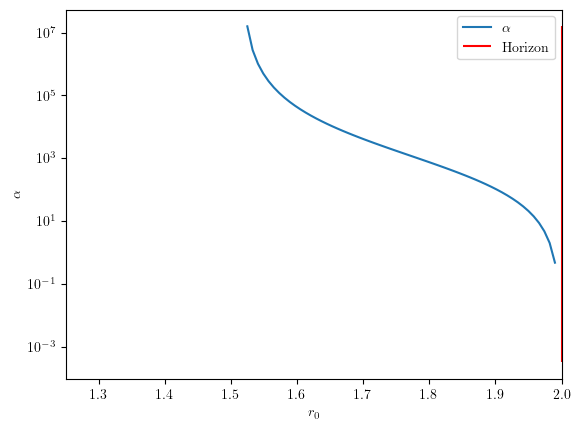

In [47]:
plt.plot(r0grid[alphamask],alphagrid[alphamask],label=r'$\alpha$')
plt.xlabel(r'$r_0$')
plt.ylabel(r'$\alpha$')
plt.vlines(R,alphagrid.min(),alphagrid.max(),colors='r',label="Horizon")
plt.semilogy()
plt.legend()
plt.xlim((1.25,2))
plt.show()

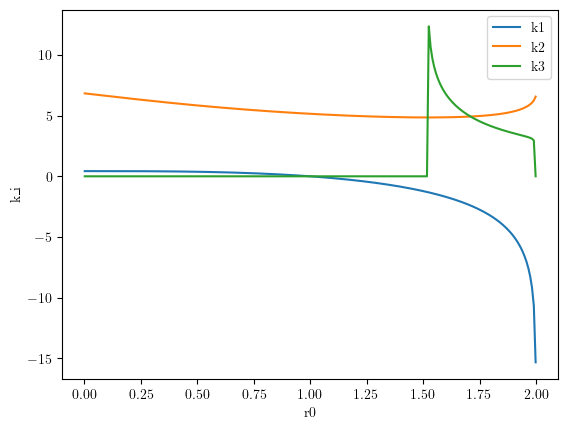

In [48]:
plt.plot(r0grid,k1grid,label='k1')
plt.plot(r0grid,k2grid,label='k2')
plt.plot(r0grid,k3grid,label='k3')
plt.xlabel('r0')
plt.ylabel('k_i')
plt.legend()
# plt.semilogx()
# plt.semilogy()
plt.show()

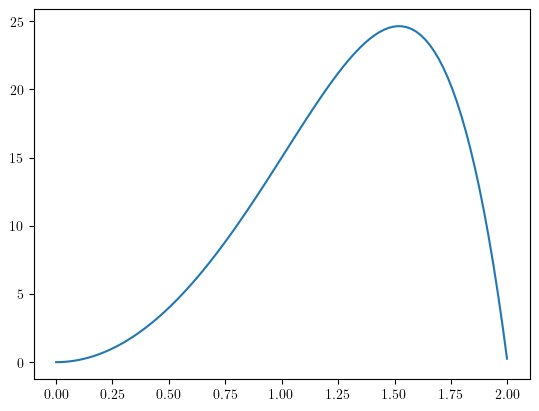

In [28]:
plt.plot(r0grid,gamma2(r0grid,R))

In [462]:
def det(rgrid,R):
    # rough estimate of r_crit in EQ 40 of 1405.7365
    eqgrid = fp(rgrid,R)*rgrid+(2*d-4)*f(rgrid,R)
    # print(f'eqgrid: {eqgrid}')
    # print(f'abseqgrid: {np.abs(eqgrid)}')
    minloc = np.argmin(np.abs(eqgrid))
    return eqgrid[minloc],rgrid[minloc]

det(np.linspace(0.001,R,1000000),R)

(2.1127816861366e-05, 1.1303961493961492)

In [463]:
# this is not consistent with what the paper expects, huh
#  time to calculate some area i guess

In [464]:
def AInteg(rgrid,r0,R):
    return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))

def divArea(rgrid,R):
    return (rgrid**(d-2)) / np.sqrt(f(rgrid,R))

In [465]:
def shockArea(r0grid,R):
    areaList = []
    area1List = [] # this guy and below are for debug
    area2List = []
    rgrid1 = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)
    divAreaInteg = divArea(rgrid1,R)
    for i in range(num):
        r0 = r0grid[i]
        rgrid2 = np.linspace(r0,R-0.1,num)
        areaInteg1 = AInteg(rgrid1,r0,R) - divAreaInteg
        area1 = np.trapezoid(areaInteg1,rgrid1)
        areaInteg2 = AInteg(rgrid2,r0,R)
        mask = np.isfinite(areaInteg2)
        area2 = np.trapezoid(areaInteg2[mask],rgrid2[mask])
        areaSum = (2 * area1) + (4 * area2)
        areaList.append(areaSum)
        area1List.append(area1)
        area2List.append(area2)
    return np.array(areaList) # , area1List, area2List

In [466]:
areaInt = shockArea(r0grid,R)

C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\2322992211.py:2: RuntimeWarning: invalid value encountered in sqrt
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\2322992211.py:2: RuntimeWarning: divide by zero encountered in divide
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))


[]

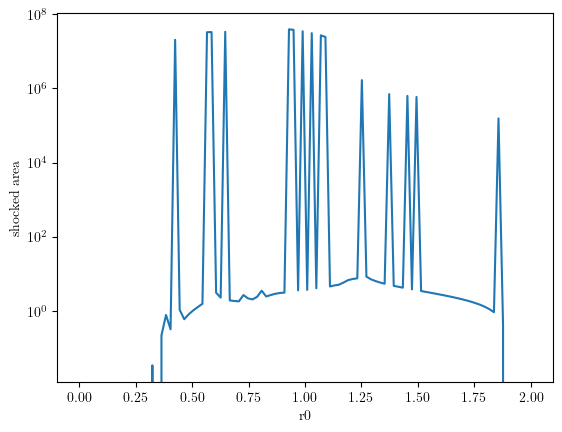

In [469]:
plt.plot(r0grid,areaInt)
plt.xlabel('r0')
plt.ylabel('shocked area')
plt.semilogy()

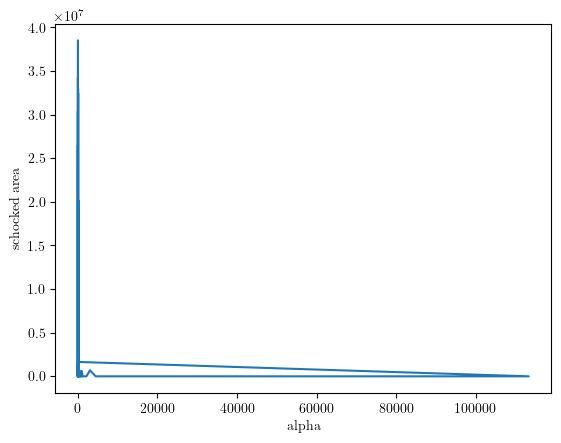

In [468]:
plt.plot(alphagrid,areaInt)
plt.xlabel('alpha')
plt.ylabel('schocked area')
plt.show()

In [357]:
alphagrid

array([1.01014871e+03, 5.86235021e+02, 4.53601285e+02, 3.76549696e+02,
       1.01357350e+03, 6.25856198e+02, 1.74270850e+03, 8.45514249e+02,
       5.82825208e+02, 1.01534128e+03, 6.62331259e+02, 1.10083130e+03,
       6.99597797e+02, 1.08338127e+03, 6.95240291e+02, 9.87610405e+02,
       1.79331759e+03, 8.60223666e+02, 1.20988214e+03, 7.34457007e+02,
       9.10841165e+02, 1.17340223e+03, 1.72811190e+03, 8.25956133e+02,
       9.47549186e+02, 1.08314209e+03, 1.23031711e+03, 1.38102975e+03,
       1.51446567e+03, 1.58819136e+03, 1.56257955e+03, 1.45889038e+03,
       1.32648272e+03, 1.19364849e+03, 1.07087441e+03, 9.60995784e+02,
       1.51849385e+03, 1.18013887e+03, 2.26005519e+03, 1.28998142e+03,
       1.94172625e+03, 1.22389531e+03, 1.47321649e+03, 1.75636234e+03,
       2.02527694e+03, 2.14781596e+03, 2.06937474e+03, 1.90329957e+03,
       1.72460326e+03, 2.69760802e+03, 2.03080028e+03, 2.63790814e+03,
       3.30417506e+03, 3.75361491e+03, 3.83008502e+03, 3.71243338e+03,
      

In [358]:
# lets relate L and rmin so we can find critical length scales later, equation 11
def Lvsrmin(rminarr,R):
    Larr = []
    for rmin in rminarr:
        rarr = np.logspace(np.log10(rmin+0.1),np.log10(rmax-1),num)
        integ = 2*l/(rarr*np.sqrt(f(rarr,R)*((rarr/rmin)**(2*d-2))-f(rarr,R)))
        L = np.trapezoid(integ,rarr)
        if np.isfinite(L):
            Larr.append(L)
        else:
            Larr.append(0)
    return np.array(Larr)

In [359]:
# now lets do the areas of unshocked regions, this area functional comes from EQ 12
# these unshocked areas are gonna be ultimately dependent on the strip width for like real params, but for now we can just punch in rmin
def unAreaInt(rminarr,R): # area for one unbroken surface
    arealist = []
    for rmin in rminarr:
        r = np.logspace(np.log10(rmin+0.1),np.log10(rmax-0.1),num)
        integ = 2 * (r**(d-2))/np.sqrt(f(r,R)-f(r,R)*((rmin/r)**(2*d-2)))
        area = np.trapezoid(integ,r)
        arealist.append(area)
    return np.array(arealist)

In [360]:
rminarr = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)

In [361]:
LvsrminArr = Lvsrmin(rminarr,R)

C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\1961872960.py:6: RuntimeWarning: divide by zero encountered in divide
  integ = 2*l/(rarr*np.sqrt(f(rarr,R)*((rarr/rmin)**(2*d-2))-f(rarr,R)))


[]

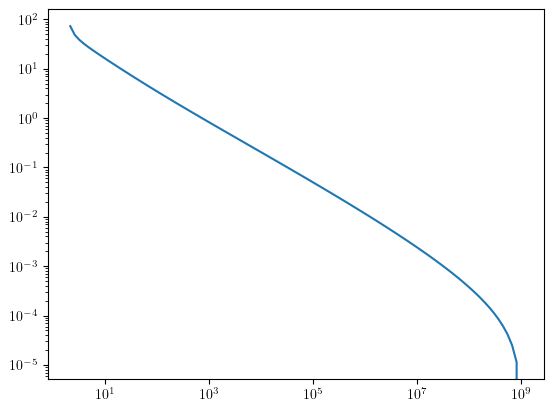

In [362]:
plt.plot(rminarr,LvsrminArr)
plt.semilogx()
plt.semilogy()

In [363]:
unArea = unAreaInt(rminarr,R)

In [364]:
unArea

array([2.00000000e+10, 2.00000000e+10, 2.00000000e+10, 2.00000000e+10,
       1.99999999e+10, 1.99999999e+10, 1.99999999e+10, 1.99999999e+10,
       1.99999999e+10, 1.99999999e+10, 1.99999999e+10, 1.99999999e+10,
       1.99999999e+10, 1.99999999e+10, 2.00000000e+10, 2.00000000e+10,
       2.00000002e+10, 2.00000003e+10, 2.00000006e+10, 2.00000009e+10,
       2.00000014e+10, 2.00000021e+10, 2.00000032e+10, 2.00000046e+10,
       2.00000066e+10, 2.00000093e+10, 2.00000131e+10, 2.00000183e+10,
       2.00000253e+10, 2.00000350e+10, 2.00000481e+10, 2.00000659e+10,
       2.00000899e+10, 2.00001224e+10, 2.00001662e+10, 2.00002252e+10,
       2.00003044e+10, 2.00004109e+10, 2.00005537e+10, 2.00007450e+10,
       2.00010010e+10, 2.00013432e+10, 2.00018004e+10, 2.00024105e+10,
       2.00032239e+10, 2.00043078e+10, 2.00057506e+10, 2.00076700e+10,
       2.00102214e+10, 2.00136104e+10, 2.00181089e+10, 2.00240755e+10,
       2.00319840e+10, 2.00424587e+10, 2.00563224e+10, 2.00746579e+10,
      

In [365]:
LvsrminArr

array([7.27279062e+01, 4.82420919e+01, 3.84251930e+01, 3.20942458e+01,
       2.73408808e+01, 2.35163593e+01, 2.03303879e+01, 1.76278790e+01,
       1.53133771e+01, 1.33208935e+01, 1.16006429e+01, 1.01128025e+01,
       8.82437980e+00, 7.70750808e+00, 6.73841860e+00, 5.89674553e+00,
       5.16500612e+00, 4.52818309e+00, 3.97337479e+00, 3.48949611e+00,
       3.06702082e+00, 2.69775919e+00, 2.37466644e+00, 2.09167800e+00,
       1.84356830e+00, 1.62582988e+00, 1.43457022e+00, 1.26642358e+00,
       1.11847597e+00, 9.88201086e-01, 8.73405781e-01, 7.72183530e-01,
       6.82874731e-01, 6.04032805e-01, 5.34395213e-01, 4.72858654e-01,
       4.18457805e-01, 3.70347082e-01, 3.27784955e-01, 2.90120458e-01,
       2.56781550e-01, 2.27265072e-01, 2.01128054e-01, 1.77980194e-01,
       1.57477326e-01, 1.39315748e-01, 1.23227286e-01, 1.08974991e-01,
       9.63493885e-02, 8.51651926e-02, 7.52584404e-02, 6.64839749e-02,
       5.87132397e-02, 5.18323422e-02, 4.57403509e-02, 4.03477968e-02,
      

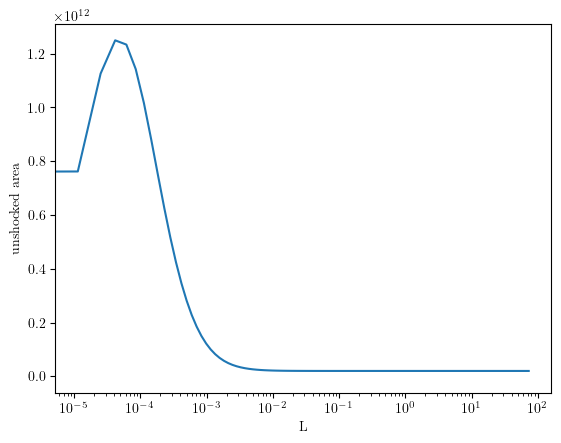

In [366]:
plt.plot(LvsrminArr,unArea)
plt.xlabel("L")
plt.ylabel("unshocked area")
plt.semilogx()
plt.show()

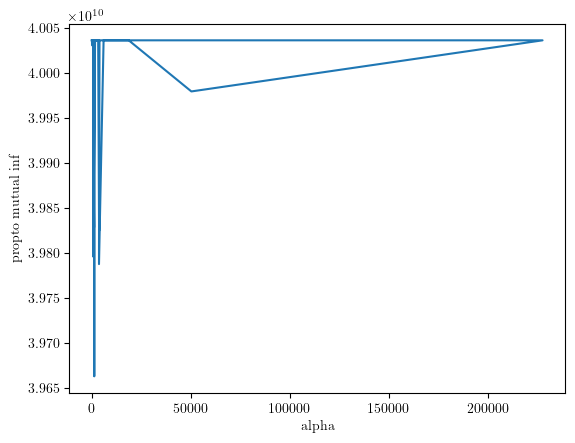

In [368]:
plt.plot(alphagrid,(2*unArea[50]-areaInt))
plt.xlabel("alpha")
plt.ylabel("propto mutual inf")
plt.show()

In [32]:
np.argmin(np.abs(2*unArea[-2]-areaInt),0)

np.int64(41)

In [33]:
# ok i have no idea what to expect from this jawn
# i guess we could plot like the Lcrit vs alpha in the flavor of figure 1?

In [124]:
def LCritFunc(Lgrid,alphagrid,unShockGrid,shockGrid):
    Lcritarr = []
    for i in range(len(alphagrid)):
        shockArea = shockGrid[i]
        mutinfGrid = 2 * unShockGrid - shockArea
        mutinfInterp = sp.interpolate.interp1d(mutinfGrid,Lgrid,fill_value="extrapolate")
        Lcrit = mutinfInterp(0)
        Lcritarr.append(Lcrit)
    return np.array(Lcritarr)
        


In [35]:
LCvsalpha = LCritFunc(LvsrminArr,alphagrid,unArea,areaInt)

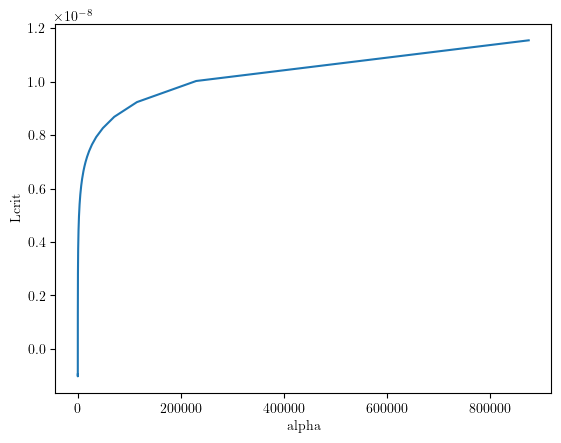

In [36]:
plt.plot(alphagrid,LCvsalpha)
plt.xlabel('alpha')
plt.ylabel('Lcrit')
# plt.semilogy()
# plt.semilogx()
plt.show()

In [37]:
# # oh god its broken lets fix it
# Lcritarr = []
# for i in range(len(alphagrid)):
#     alpha = alphagrid[i]
#     # print(alpha)
#     shockArea = areaInt[i]
#     # print(shockArea)
#     mutinfGrid = 2 * unArea - shockArea
#     with open('mutinfgrid.txt','a') as f:
#         print(f'\n {mutinfGrid}',file=f)
#     mutinfInterp = sp.interpolate.interp1d(mutinfGrid,LvsrminArr,fill_value="extrapolate")
#     Lcrit = mutinfInterp(0)
#     print(Lcrit)
#     # critIdx = np.argmin(np.abs(mutinfGrid)) # this precision sucks, a better way to do in future is interpolate but im not troubleshooting that rn

#     # print(critIdx)
#     # Lcrit = LvsrminArr[critIdx]
#     # print(Lcrit)
#     Lcritarr.append(Lcrit)
# Lcritarr = np.array(Lcritarr)

In [61]:
# lets make some big functions that work at different temperatures to put in the big boy python script

In [82]:
def genAlphaPlot(Rmin,Rmax,Rnum,Rtyp='lin'):
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0
    
    for R in Rgrid:
        r0grid = np.linspace(r0min,0.999*R,num)
        alphagrid = alpha(r0grid,R)
        plt.plot(r0grid,alphagrid,label=f'R = {R:.3f}')

    plt.xlabel(r'$r_0$')
    plt.ylabel(r'$\alpha$')
    # plt.vlines(R,alphagrid.min(),alphagrid.max(),colors='r',label="Horizon")
    plt.semilogy()
    plt.legend()
    plt.show()

    # for plotting of k functions at different temperatures, uncomment. makes many a plot, not reccommended
    # k1grid = k1(r0grid,R)
    # k2grid = k2(r0grid,R)
    # k3grid = k3(r0grid,R)

    # plt.plot(r0grid,k1grid,label='k1')
    # plt.plot(r0grid,k2grid,label='k2')
    # plt.plot(r0grid,k3grid,label='k3')
    # plt.xlabel('r0')
    # plt.ylabel('k_i')
    # plt.legend()
    # # plt.semilogx()
    # plt.semilogy()
    # plt.show()

C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\687661607.py:29: RuntimeWarning: divide by zero encountered in divide
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\687661607.py:29: RuntimeWarning: invalid value encountered in sqrt
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\3174369111.py:2: RuntimeWarning: overflow encountered in exp
  return 2*np.exp(k1(r0grid,R)+k2(r0grid,R)+k3(r0grid,R))


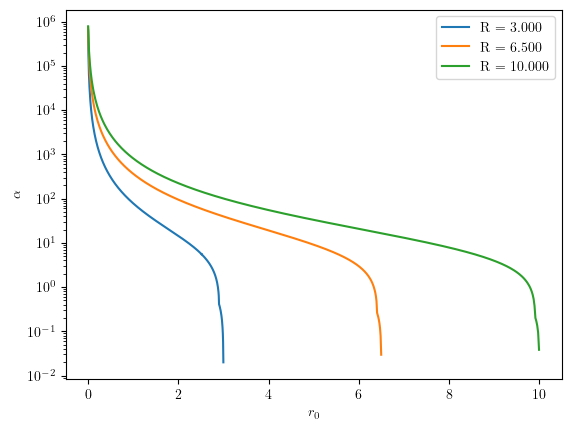

In [83]:
genAlphaPlot(3,10,3,'lin')

In [84]:
def genShockPlot(Rmin,Rmax,Rnum,Rtyp='lin'):
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0
    
    for R in Rgrid:
        r0grid = np.logspace(np.log10(r0min),np.log10(0.999*R),num)
        alphagrid = alpha(r0grid,R)
        areaInt = shockArea(r0grid,R)
        plt.plot(alphagrid,areaInt,label=f'R = {R:.3f}')
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'Area$_{A \cup B}$')
    plt.legend()
    # plt.semilogx()
    # plt.semilogy()
    plt.show()

C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\687661607.py:29: RuntimeWarning: divide by zero encountered in divide
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\687661607.py:29: RuntimeWarning: invalid value encountered in sqrt
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\2322992211.py:2: RuntimeWarning: divide by zero encountered in divide
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\2322992211.py:2: RuntimeWarning: invalid value encountered in sqrt
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))


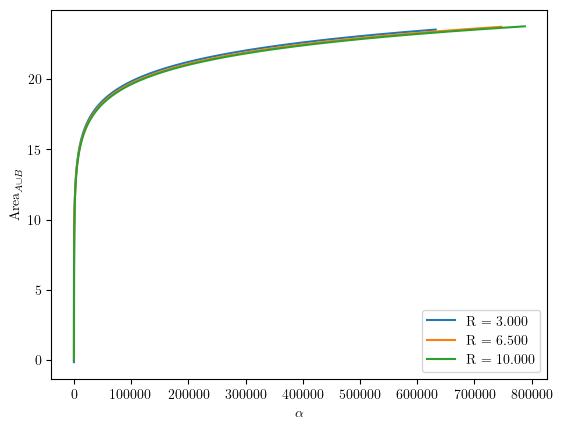

In [85]:
genShockPlot(3,10,3)

In [86]:
def genLvsrminPlot(Rmin,Rmax,Rnum,Rtyp='lin',rminmax=rmax):
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0
    
    for  R in Rgrid:
        rminarr = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)
        LvsrminArr = Lvsrmin(rminarr,R)
        plt.plot(rminarr,LvsrminArr,label=f'R = {R:.3f}')
    
    plt.xlabel(r'$r_{min}$')
    plt.ylabel(r'$L$')
    plt.xlim((2,rminmax))
    plt.legend()
    plt.semilogx()
    # plt.semilogy()
    plt.show()

C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\1961872960.py:6: RuntimeWarning: divide by zero encountered in divide
  integ = 2*l/(rarr*np.sqrt(f(rarr,R)*((rarr/rmin)**(2*d-2))-f(rarr,R)))


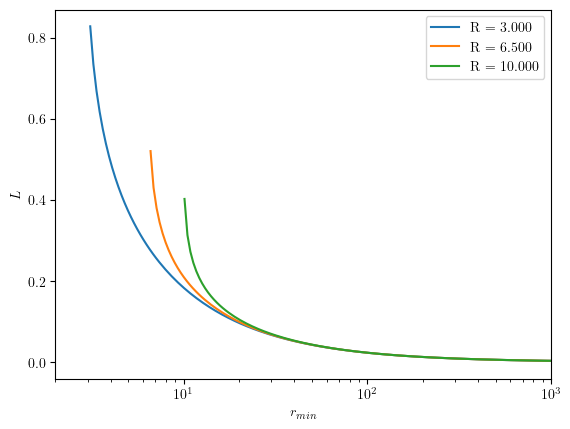

In [88]:
genLvsrminPlot(3,10,3,'lin',1000)

In [97]:
def genUnAreaPlot(Rmin,Rmax,Rnum,Rtyp='lin'):
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0
    
    for  R in Rgrid:
        rminarr = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)
        LArr = Lvsrmin(rminarr,R)
        unArea = unAreaInt(rminarr,R)
        plt.plot(LArr,unArea,label=f'R = {R:.3f}')
    
    plt.xlabel(r'$L$')
    plt.ylabel(r'Area$_{A}$')
    plt.semilogx()
    # plt.semilogy()
    plt.legend()
    plt.show()

C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\1961872960.py:6: RuntimeWarning: divide by zero encountered in divide
  integ = 2*l/(rarr*np.sqrt(f(rarr,R)*((rarr/rmin)**(2*d-2))-f(rarr,R)))


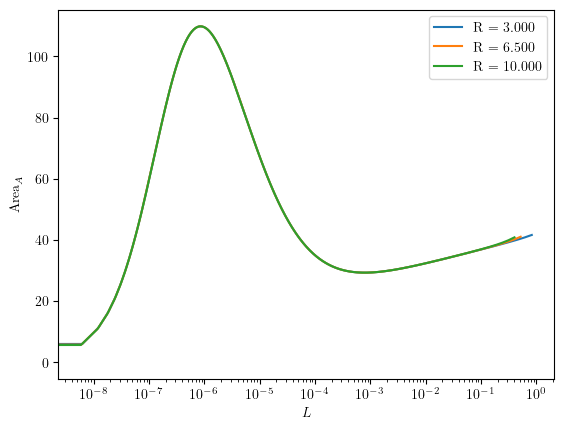

In [98]:
genUnAreaPlot(3,10,3)

In [122]:
def genMutInfPlot(Rmin,Rmax,Rnum,Rtyp='lin',Lidx=(num/2)):
    # can only give general shape of mutual information, as the "y" location is determined by the width of regions A and B
    # we will just pick a random index for now as default
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0
    
    Lidx = np.array(int(Lidx))

    for R in Rgrid:
        r0grid = np.logspace(np.log10(r0min),np.log10(0.999*R),num)
        rminarr = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)
        alphagrid = alpha(r0grid,R)
        unArea = unAreaInt(rminarr,R)
        areaInt = shockArea(r0grid,R)
        mutInf = 2*unArea[Lidx] - areaInt
        plt.plot(alphagrid,mutInf,label=f'R = {R:.3f}')
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\propto I(A,B)$')
    plt.legend()
    plt.semilogx()
    # plt.semilogy()
    plt.show()

C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\687661607.py:29: RuntimeWarning: divide by zero encountered in divide
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\687661607.py:29: RuntimeWarning: invalid value encountered in sqrt
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\2322992211.py:2: RuntimeWarning: divide by zero encountered in divide
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\2322992211.py:2: RuntimeWarning: invalid value encountered in sqrt
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))


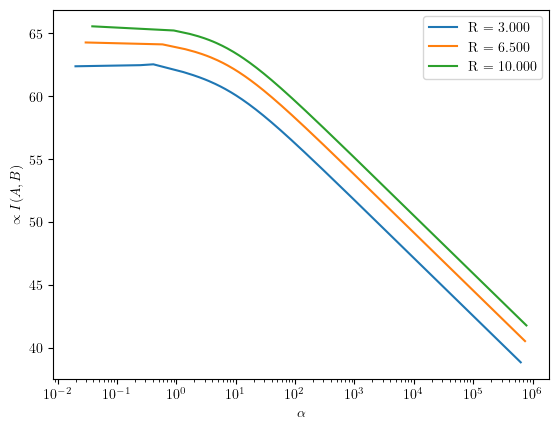

In [123]:
genMutInfPlot(3,10,3)

In [155]:
def genLCritPlot(Rmin,Rmax,Rnum,Rtyp='lin'):
    if Rtyp == 'lin':
        Rgrid = np.linspace(Rmin,Rmax,Rnum)
    elif Rtyp == 'log':
        Rgrid = np.logspace(np.log10(Rmin),np.log10(Rmax),Rnum)
    else:
        print('Invalid Rtyp, use lin or log')
        return 0

    for R in Rgrid:
        r0grid = np.logspace(np.log10(r0min),np.log10(0.999*R),num)
        rminarr = np.logspace(np.log10(R+0.1),np.log10(rmax-1),num)
        LArr = Lvsrmin(rminarr,R)
        alphagrid = alpha(r0grid,R)
        unArea = unAreaInt(rminarr,R)
        areaInt = shockArea(r0grid,R)
        LCArr = LCritFunc(LArr,alphagrid,unArea,areaInt)
        plt.plot(alphagrid,LCArr,label=f'R = {R:.3f}')
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$L_{crit.}$')
    plt.legend()
    plt.semilogx()
    # plt.semilogy()
    # plt.xlim((0.1,100))
    plt.show()

C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\1961872960.py:6: RuntimeWarning: divide by zero encountered in divide
  integ = 2*l/(rarr*np.sqrt(f(rarr,R)*((rarr/rmin)**(2*d-2))-f(rarr,R)))
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\687661607.py:29: RuntimeWarning: divide by zero encountered in divide
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\687661607.py:29: RuntimeWarning: invalid value encountered in sqrt
  integ = (1 - 1/(np.sqrt(1+f(rgrid,R)*(rgrid**(2*d-4))/(gamma2(r0,R)))))/f(rgrid,R)
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\2322992211.py:2: RuntimeWarning: divide by zero encountered in divide
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))
C:\Users\bkoro\AppData\Local\Temp\ipykernel_39688\2322992211.py:2: RuntimeWarning: invalid value encountered in sqrt
  return (rgrid**(d-2)) / np.sqrt(f(rgrid,R) + gamma2(r0,R)*(rgrid**(4-2*d)))


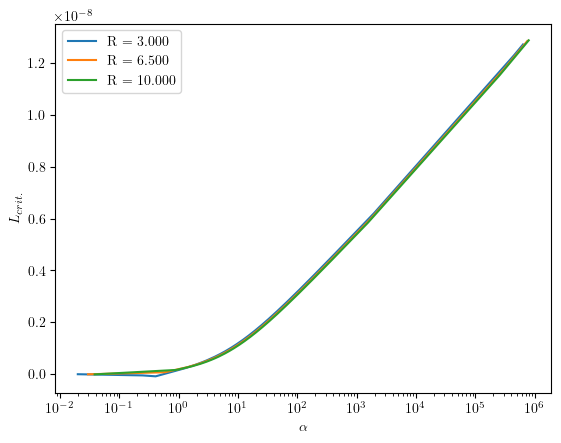

In [156]:
genLCritPlot(3,10,3)